# Single Cell Analysis of Quenched Slides

**Question:** How does autofluorescence change over repeated quenching reactions?

**Samples:** Three normal pancrease tissue sections were processed with the cyclif IF protocol, then repeatedly quenched for 15 minutes and imaged. No anitbody was applied. Quenching solution contained 3%, 4.5% and 6% H2O2, but no difference in quenching speed or completeness was observed between the conditions.

**Method**: Slides were imaged as described above, registered and segmented based on DAPI stain. Nuclei were inflated by 5 pixels to roughly capture cytoplasmic signal.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import matplotlib
import seaborn as sns
matplotlib.rcParams.update({'font.size': 15})
import umap
from sklearn.preprocessing import scale
import scanpy as sc

In [5]:
#set location of files
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir = os.getcwd()

# Import and Filter Data

In [6]:
#import single cell intensity data
ls_sample = ['4165NPanc-74','4165NPanc-76','4165NPanc-78']
df_data = pd.DataFrame()
df_xy=pd.DataFrame()
for s_sample in ls_sample:
    print(s_sample)
    df = pd.read_csv(f'{codedir}/Data/Quench/features_{s_sample}_FilteredMeanIntensity_DAPI6_DAPI1.csv',index_col=0)
    df['sample'] = s_sample
    df_data = df_data.append(df)
    df_xy = df_xy.append(pd.read_csv(f'{codedir}/Data/Quench/features_{s_sample}_CentroidXY.csv',index_col=0))


4165NPanc-74
4165NPanc-76
4165NPanc-78


In [7]:
#select nucleus and 5 pixels around nucleus (perinuc5) mean intensity features
ls_cyto = sorted(df_data.columns[(df_data.columns.str.contains('perinuc5')) & (~df_data.columns.str.contains('DAPI')) & (~df_data.columns.str.contains('R6'))]) 
ls_nuc = [item.split('_')[0] + '_nuclei' for item in ls_cyto] 
ls_cyto = ls_cyto + ['sample']
df_cyto = df_data.loc[:,ls_cyto].dropna()
df_nuc = df_data.loc[:,ls_nuc].dropna()
df_both = df_data.loc[:,ls_cyto+ls_nuc].dropna()

In [5]:
# analyze only channel 2 nd 3 (488 and 555)
df_af = df_both.loc[:,(df_both.columns.str.contains('c2') |  df_both.columns.str.contains('sample'))] #df_both.columns.str.contains('c3') | #shading artifact

#sort column names
df_af = df_af.loc[:,sorted(df_af.columns)]

In [6]:
# save as csv for scanpy
df_af.columns = [item.replace('_nuclei','_nuc') for item in df_af.columns]
df_af.columns = [item.replace('_perinuc5','_cyt') for item in df_af.columns]
df_af.drop('sample',axis=1).to_csv(f'{codedir}/Data/Quench/features_4165NPanc_AF_scanpy.csv')

# Scanpy

single cell analysis

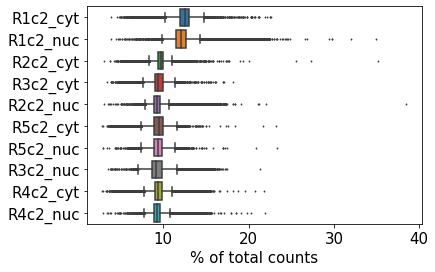

In [8]:
filename = f'{codedir}/Data/Quench/features_4165NPanc_AF_scanpy.csv'
adata = sc.read_csv(filename)
fig,ax=plt.subplots()
sc.pl.highest_expr_genes(adata, n_top=12,ax=ax)
fig.savefig(f'{codedir}/Figures/4165NPanc/4165NPanc_RankedExpression.png',dpi=200)

#adata.obs
adata.obs['tissue'] = [item.split('_scene')[0].split('4165')[1] for item in adata.obs.index]

... storing 'tissue' as categorical


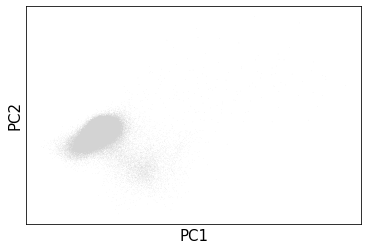

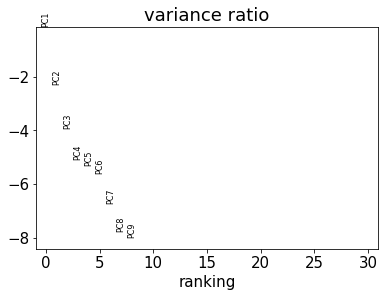

In [9]:
#log transform, batch correct reduce dimensionality (PCA)
sc.pp.log1p(adata)
adata.raw = adata
#sc.pp.scale(adata, max_value=50) don't scale since all are same exposure

#remove batch effect
sc.pp.combat(adata,key='tissue')

#reduce dimensionality
sc.tl.pca(adata, svd_solver='auto')
fig, ax = plt.subplots()
sc.pl.pca(adata,ax=ax)
sc.pl.pca_variance_ratio(adata, log=True)


In [10]:
#raw umap
filename = f'{codedir}/Data/Quench/features_4165NPanc_AF_scanpy.csv'
rdata = sc.read_csv(filename)
rdata.obs['tissue'] = [item.split('_scene')[0].split('4165')[1] for item in rdata.obs.index]
rdata.raw = rdata
#log transform, reduce dimensionality (PCA)
sc.pp.log1p(rdata)

#don't remove batch effect
#sc.pp.combat(adata,key='tissue')

#reduce dimensionality
sc.tl.pca(rdata, svd_solver='auto')
sc.pp.neighbors(rdata, n_neighbors=10, n_pcs=9)
sc.tl.umap(rdata)


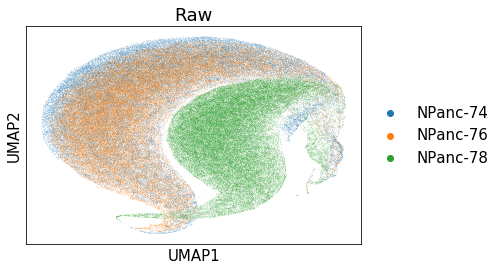

<Figure size 432x288 with 0 Axes>

In [55]:
#umap plot
figname = f'{codedir}/Figures/4165NPanc/4165NPanc_UmapRaw.png'
fig = sc.pl.umap(rdata, color='tissue',save=figname,return_fig=True,title='Raw')

plt.show(fig)
plt.tight_layout()
fig.savefig(figname)

In [11]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=9)
sc.tl.umap(adata)

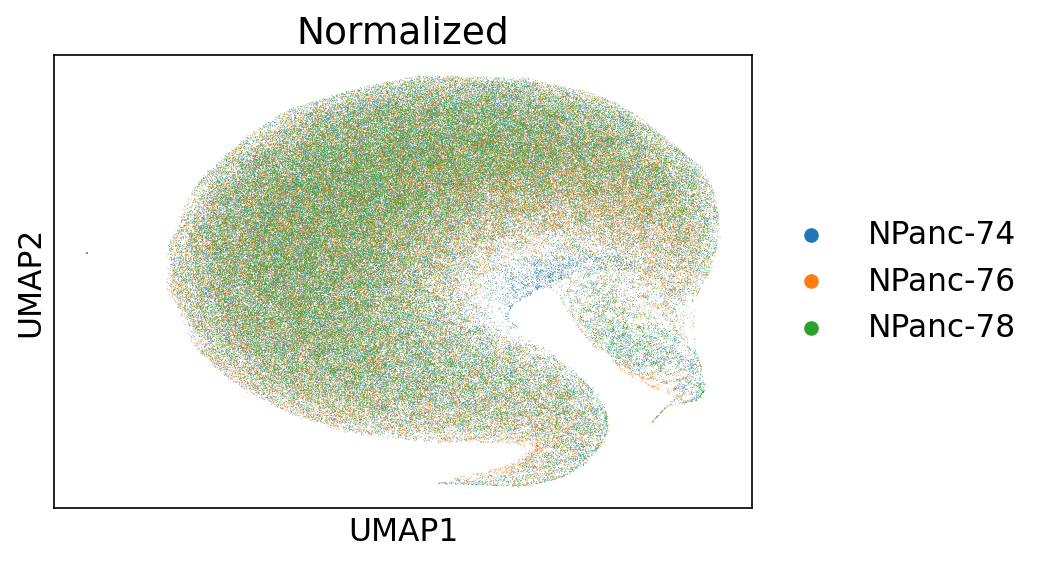

In [16]:
#umap plot
figname = f'4165NPanc_UmapBatch.png'
fig, ax = plt.subplots(dpi=150)
sc.pl.umap(adata, color='tissue',use_raw=True,save=figname,title='Normalized',ax=ax)
plt.show(fig)

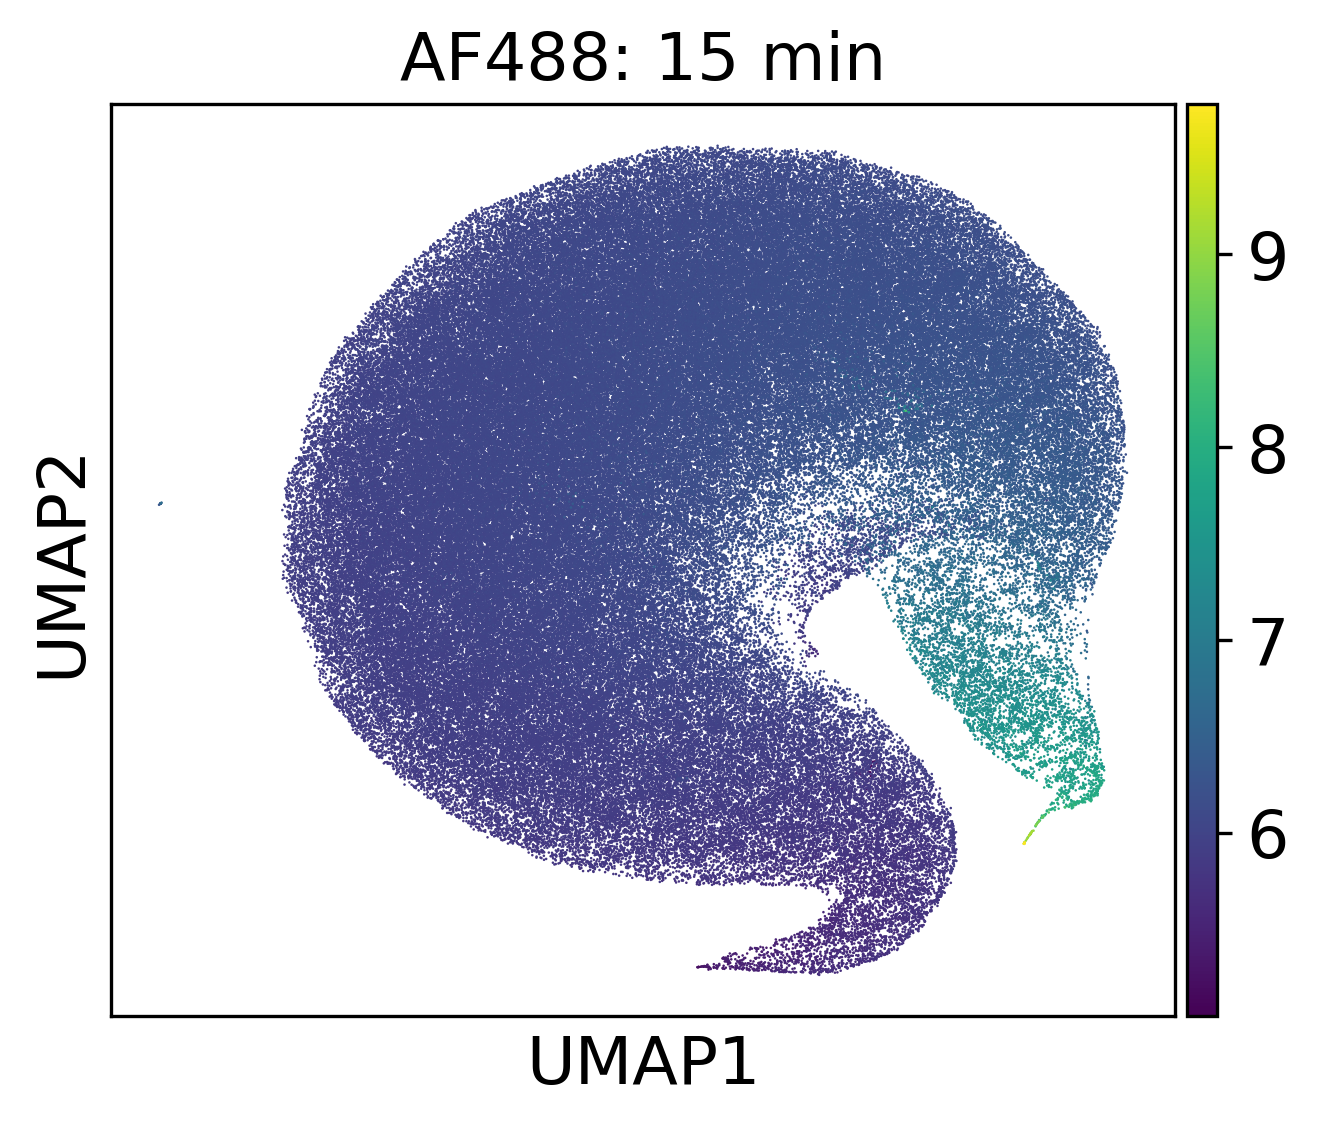

<Figure size 320x320 with 0 Axes>

In [55]:
# umap plus expression
sc.set_figure_params(fontsize=16)
figname = f'4165NPanc_R2c2_nuc.png'
fig, ax = plt.subplots(figsize = (5,4),dpi=150)
sc.pl.umap(adata, color='R2c2_nuc',size=1.5,save=figname, wspace=0.2,title='AF488: 15 min',ax=ax)
plt.tight_layout()
plt.show(fig)

In [56]:
fig.savefig(figname,bbox_inches='tight')

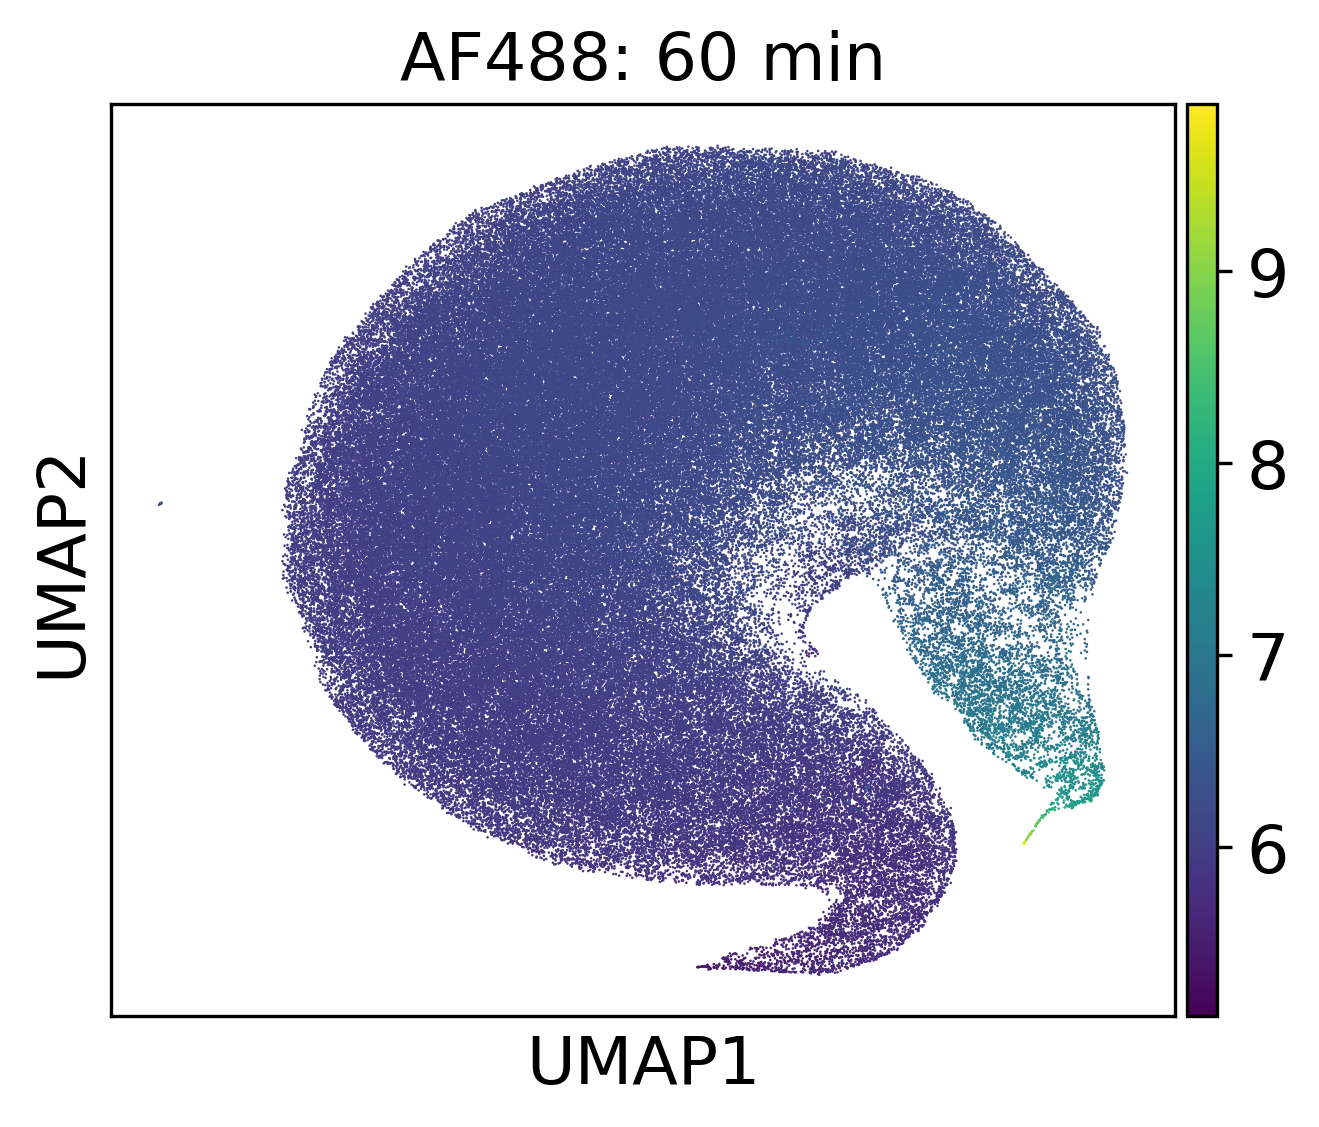

<Figure size 320x320 with 0 Axes>

In [57]:
# umap plus expression
sc.set_figure_params(fontsize=16)
figname = f'4165NPanc_R5c2_nuc.png'
fig, ax = plt.subplots(figsize = (5,4),dpi=150)
sc.pl.umap(adata, color='R5c2_nuc',size=1.5,save=figname, wspace=0.2,title='AF488: 60 min',ax=ax)
plt.tight_layout()
plt.show(fig)

In [58]:
fig.savefig(figname,bbox_inches='tight')

In [19]:
#cluster
sc.tl.leiden(adata, resolution = 0.3)

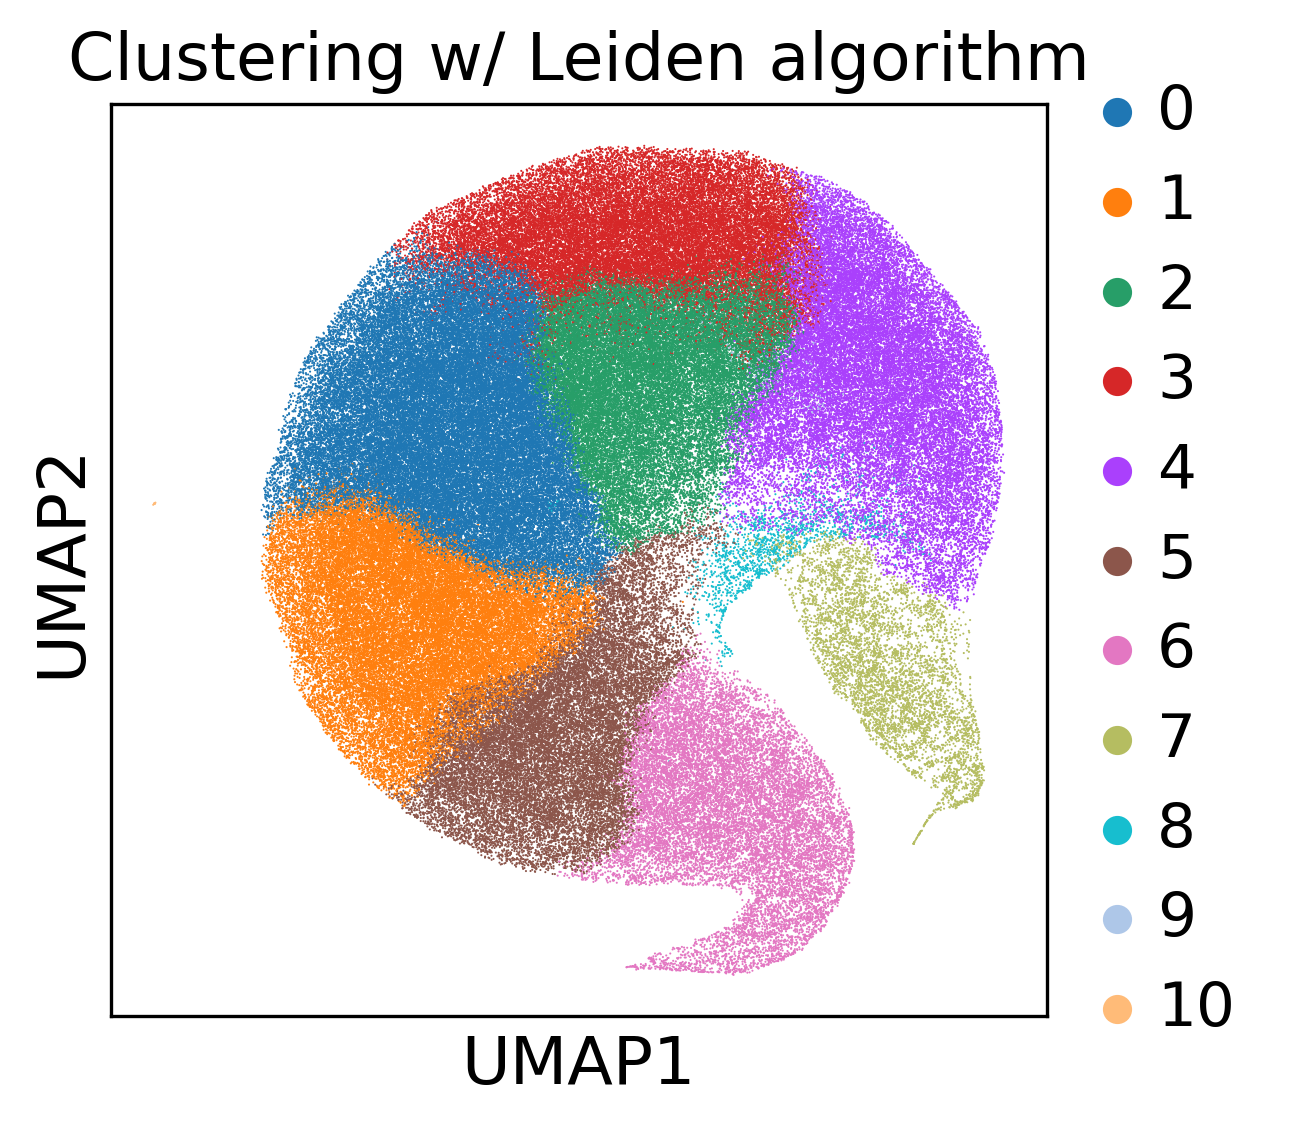

<Figure size 320x320 with 0 Axes>

In [37]:
# umap plus clustering result 
sc.set_figure_params(fontsize=16)
figname = f'4165NPanc_UmapLeiden.png'
fig, ax = plt.subplots(figsize = (4,4),dpi=150)
sc.pl.umap(adata, color='leiden',size=1,save=figname, wspace=0.2,title='Clustering w/ Leiden algorithm',ax=ax)
plt.tight_layout()
plt.show(fig)

In [38]:
fig.savefig(figname,bbox_inches='tight')

# Plot Clustering Results

In [3]:
#load leiden clusters
adata = sc.read_h5ad(f'{codedir}/Data/4165NPanc_AF_norm_leiden.h5ad')

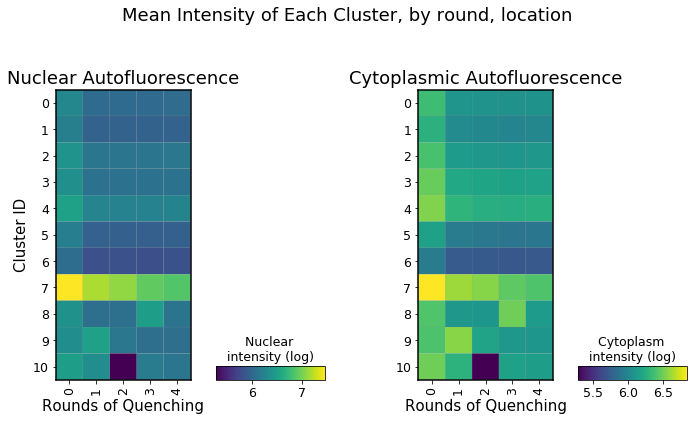

In [44]:
# inspect clusters
marker_genes = ['R1c2_nuc','R2c2_nuc','R3c2_nuc','R4c2_nuc','R5c2_nuc']
marker_genes_cyt = ['R1c2_cyt','R2c2_cyt','R3c2_cyt','R4c2_cyt','R5c2_cyt']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1_dict = sc.pl.matrixplot(adata, marker_genes, groupby='leiden', ax=ax1,show=False,dendrogram=False, cmap='viridis', use_raw=True, colorbar_title='Nuclear \nintensity (log)')
ax2_dict = sc.pl.matrixplot(adata, marker_genes_cyt, groupby='leiden',ax=ax2,show=False, dendrogram=False, cmap='viridis', use_raw=True, colorbar_title='Cytoplasm \nintensity (log)')
ax1_dict['mainplot_ax'].set_xlabel('Rounds of Quenching')
ax1_dict['mainplot_ax'].set_xticklabels(['0','1','2','3','4'])
ax1_dict['mainplot_ax'].set_title('Nuclear Autofluorescence')
ax1_dict['mainplot_ax'].set_ylabel('Cluster ID')
ax2_dict['mainplot_ax'].set_xlabel('Rounds of Quenching')
ax2_dict['mainplot_ax'].set_xticklabels(['0','1','2','3','4'])
ax2_dict['mainplot_ax'].set_title('Cytoplasmic Autofluorescence')
fig.suptitle(f'Mean Intensity of Each Cluster, by round, location')
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/4165NPanc/4165NPanc_MatrixPlot_Leiden.png',dpi=200)


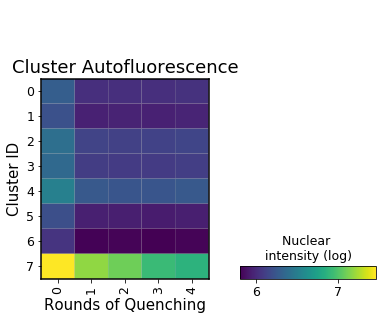

In [42]:
fig,ax =plt.subplots(figsize=(6,5))
adata_new = adata[~adata.obs['leiden'].isin(['8','9','10']),:]
axes_dict = sc.pl.matrixplot(adata_new, marker_genes, groupby='leiden', ax=ax,show=False,dendrogram=False, cmap='viridis', use_raw=True, colorbar_title='Nuclear \nintensity (log)')
axes_dict['mainplot_ax'].set_title('Cluster Autofluorescence')
axes_dict['mainplot_ax'].set_xlabel('Rounds of Quenching')
axes_dict['mainplot_ax'].set_ylabel('Cluster ID')
axes_dict['mainplot_ax'].set_xticklabels(['0','1','2','3','4'])
fig.savefig(f'{codedir}/Figures/4165NPanc/4165NPanc_MatrixPlot7_Leiden.png',dpi=200)

In [13]:
def plot_clusters(df_cluster,df_xy):
    s_type = df_cluster.columns[df_cluster.dtypes=='int64'][0]
    print(s_type)
    ls_scene = sorted(set(df_cluster.slide_scene))
    ls_color = sorted(set(df_cluster.loc[:,s_type].dropna()))
    ls_fig = []
    for s_scene in ls_scene:
        #negative cells = all cells even before dapi filtering
        df_neg = df_xy[(df_xy.slide_scene==s_scene)]
        #plot
        fig, ax = plt.subplots(6, 2, figsize=(12,16),dpi=200)
        ax = ax.ravel()
        for ax_num, s_color in enumerate(ls_color):
            s_marker = s_color
            #positive cells = poitive cells based on threshold
            ls_pos_index = (df_cluster[df_cluster.loc[:,s_type]==s_color]).index
            df_color_pos = df_neg[df_neg.index.isin(ls_pos_index)]
            if len(df_color_pos)>=1:
                #plot negative cells
                ax[ax_num].scatter(data=df_neg,x='DAPI_X',y='DAPI_Y',color='silver',s=1)
                #plot positive cells
                ax[ax_num].scatter(data=df_color_pos, x='DAPI_X',y='DAPI_Y',color='DarkBlue',s=.5)
                  
                ax[ax_num].axis('equal')
                ax[ax_num].set_ylim(ax[ax_num].get_ylim()[::-1])
                ax[ax_num].set_xticklabels('')
                ax[ax_num].set_yticklabels('')
                ax[ax_num].set_title(f'{s_color} ({len(df_color_pos)} cells)')
            else:
                ax[ax_num].set_xticklabels('')
                ax[ax_num].set_yticklabels('')
                ax[ax_num].set_title(f'{s_color}  ({(0)} cells')
        
        fig.suptitle(s_scene)
        ls_fig.append(fig)
    return(ls_fig)

leiden


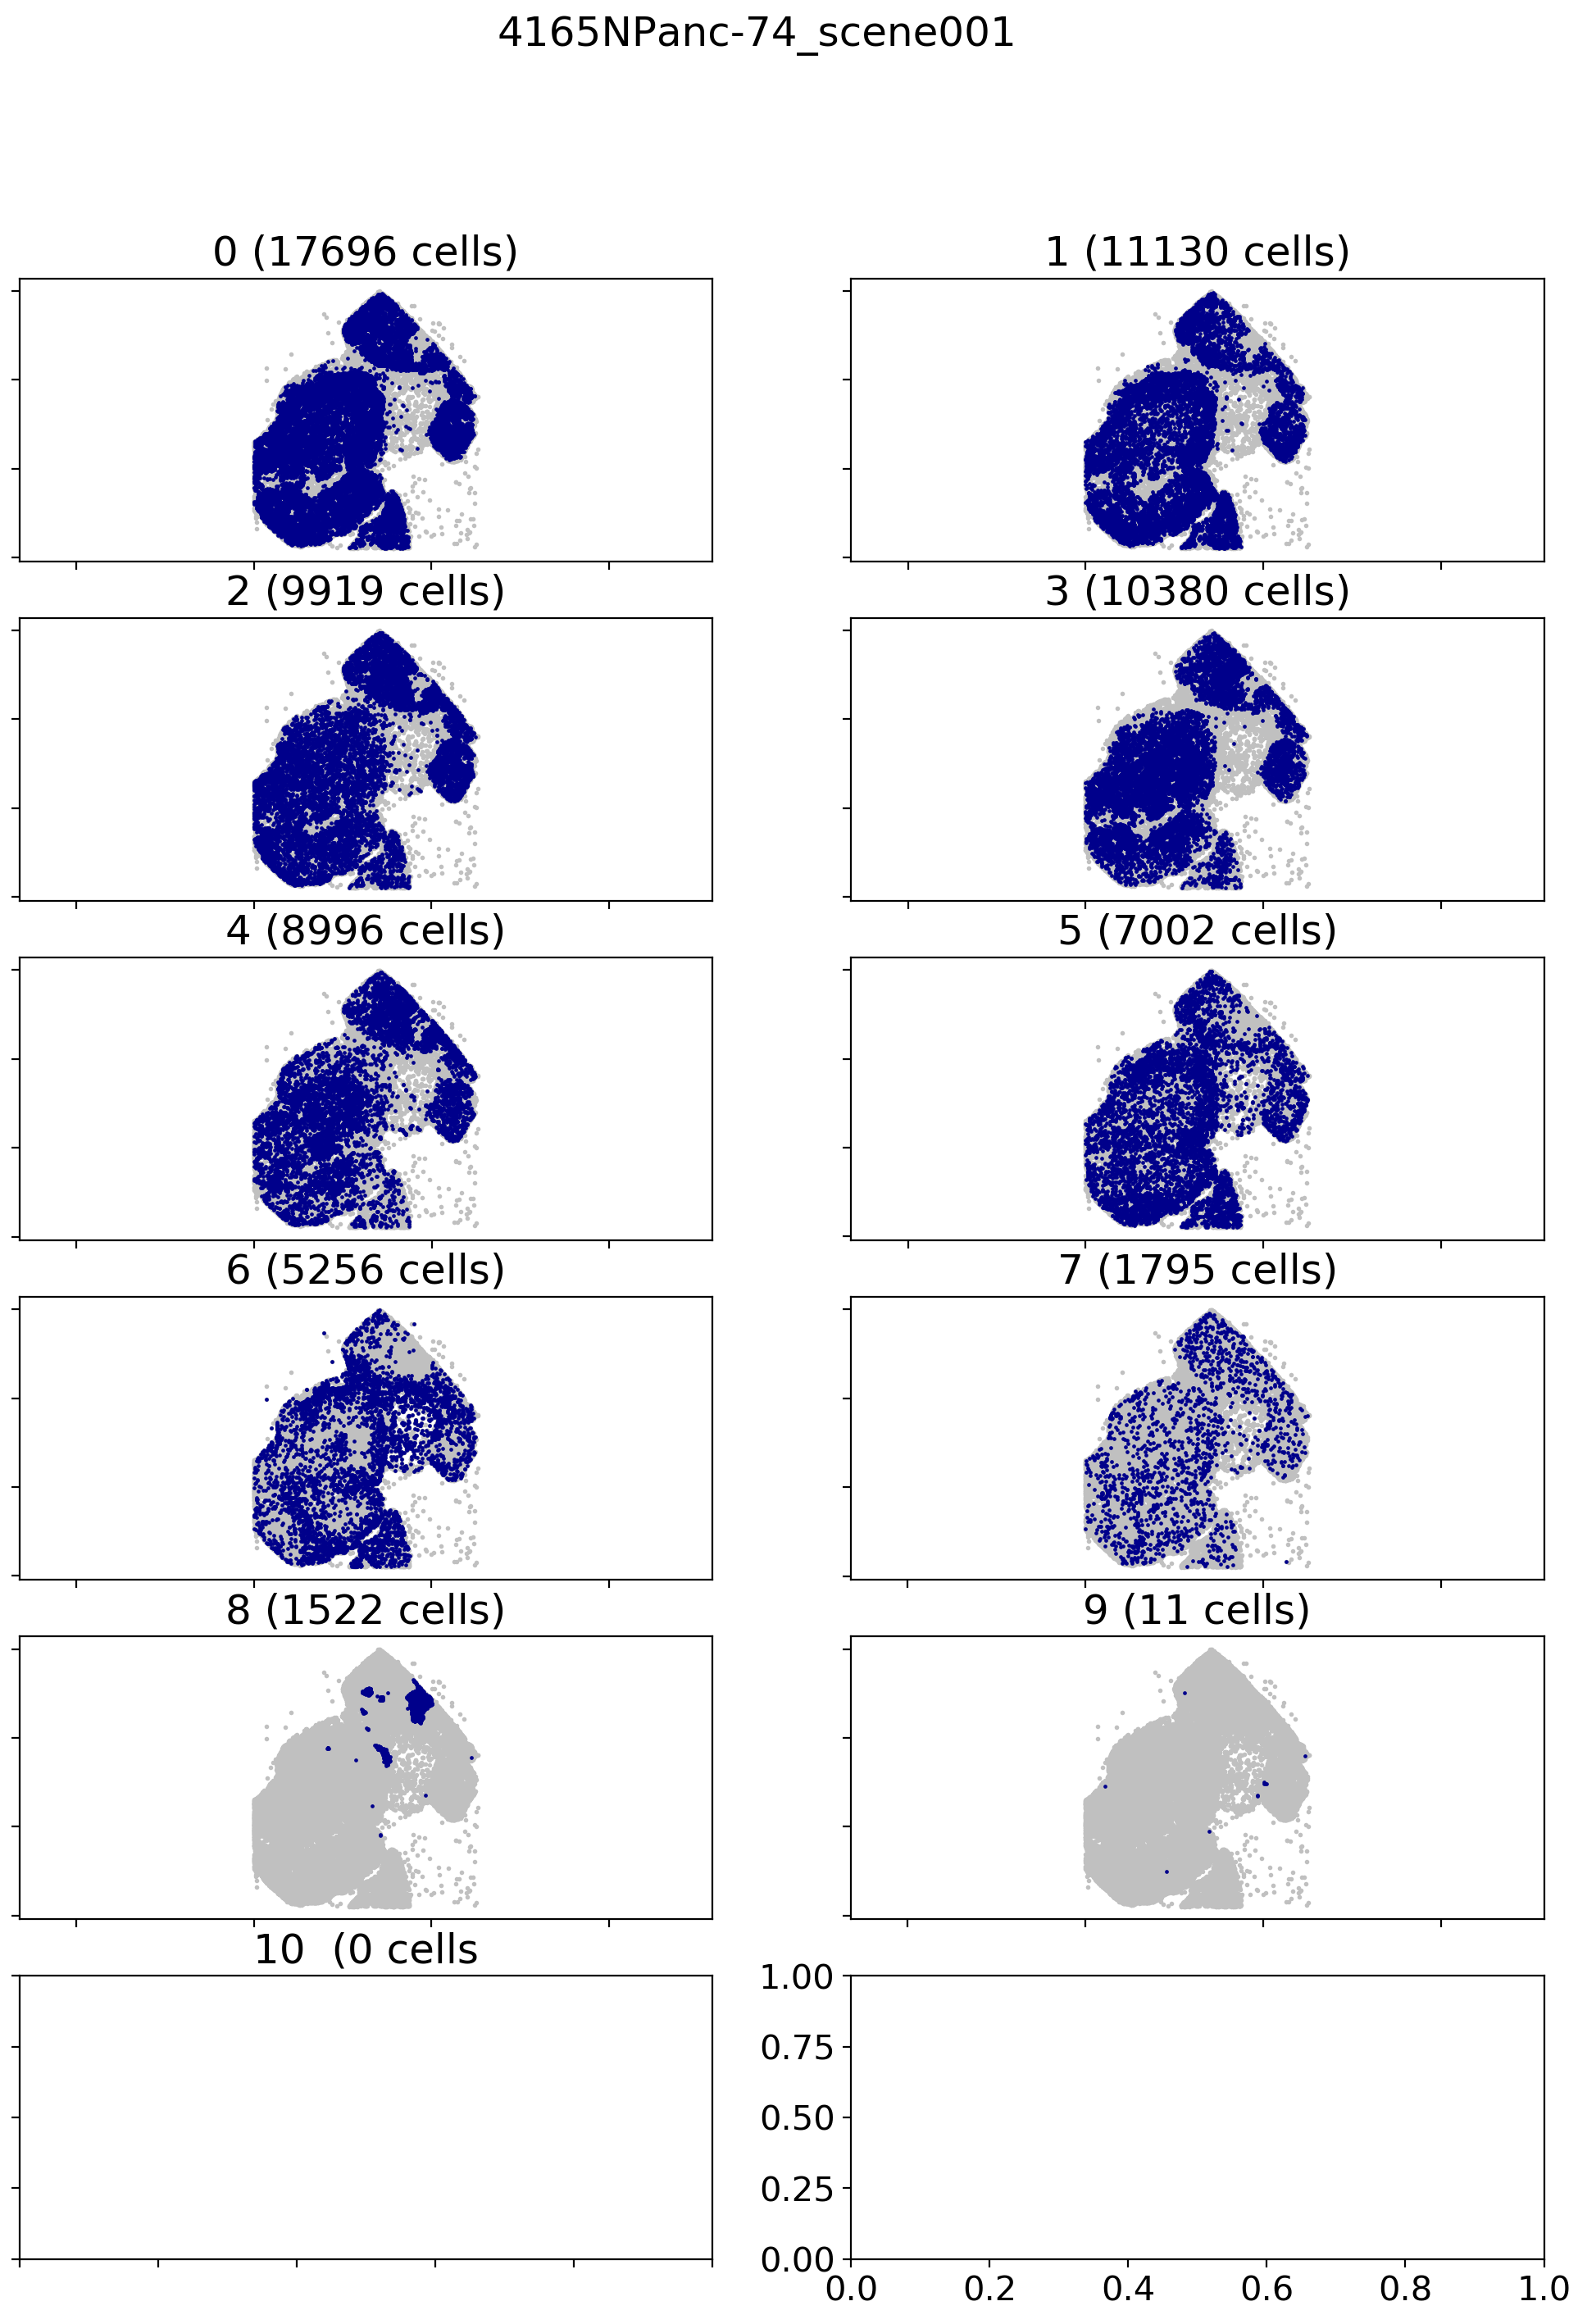

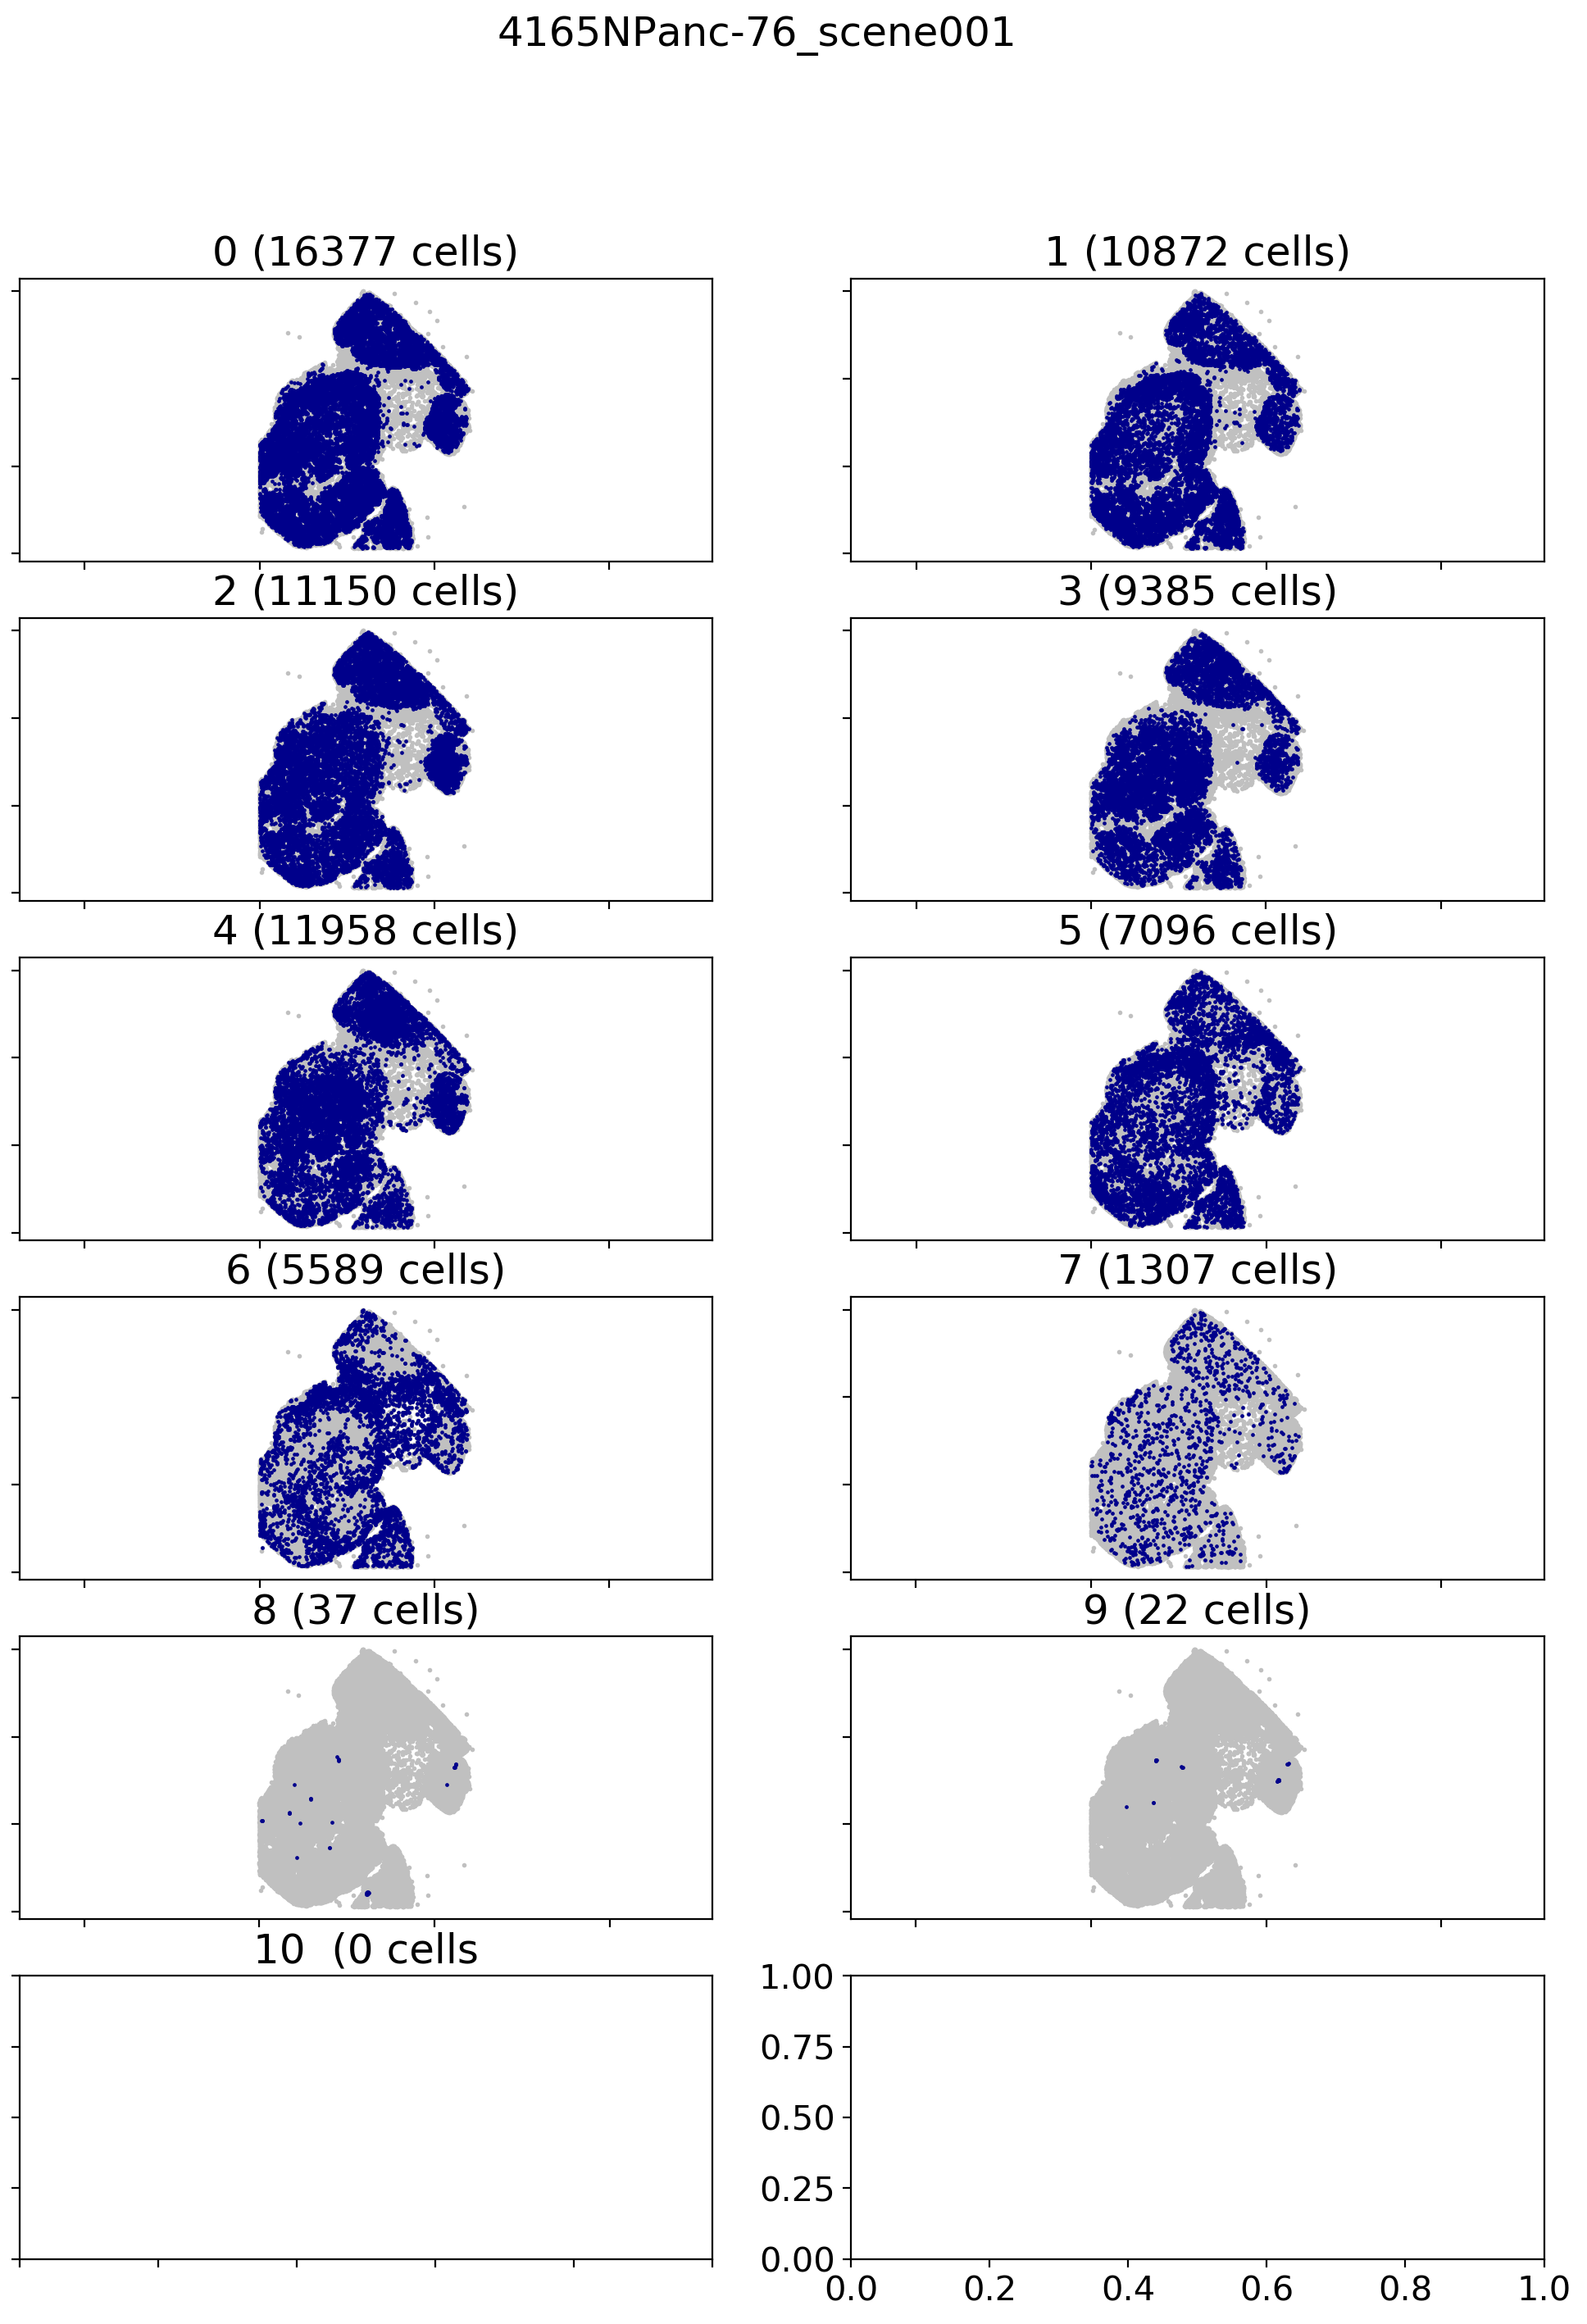

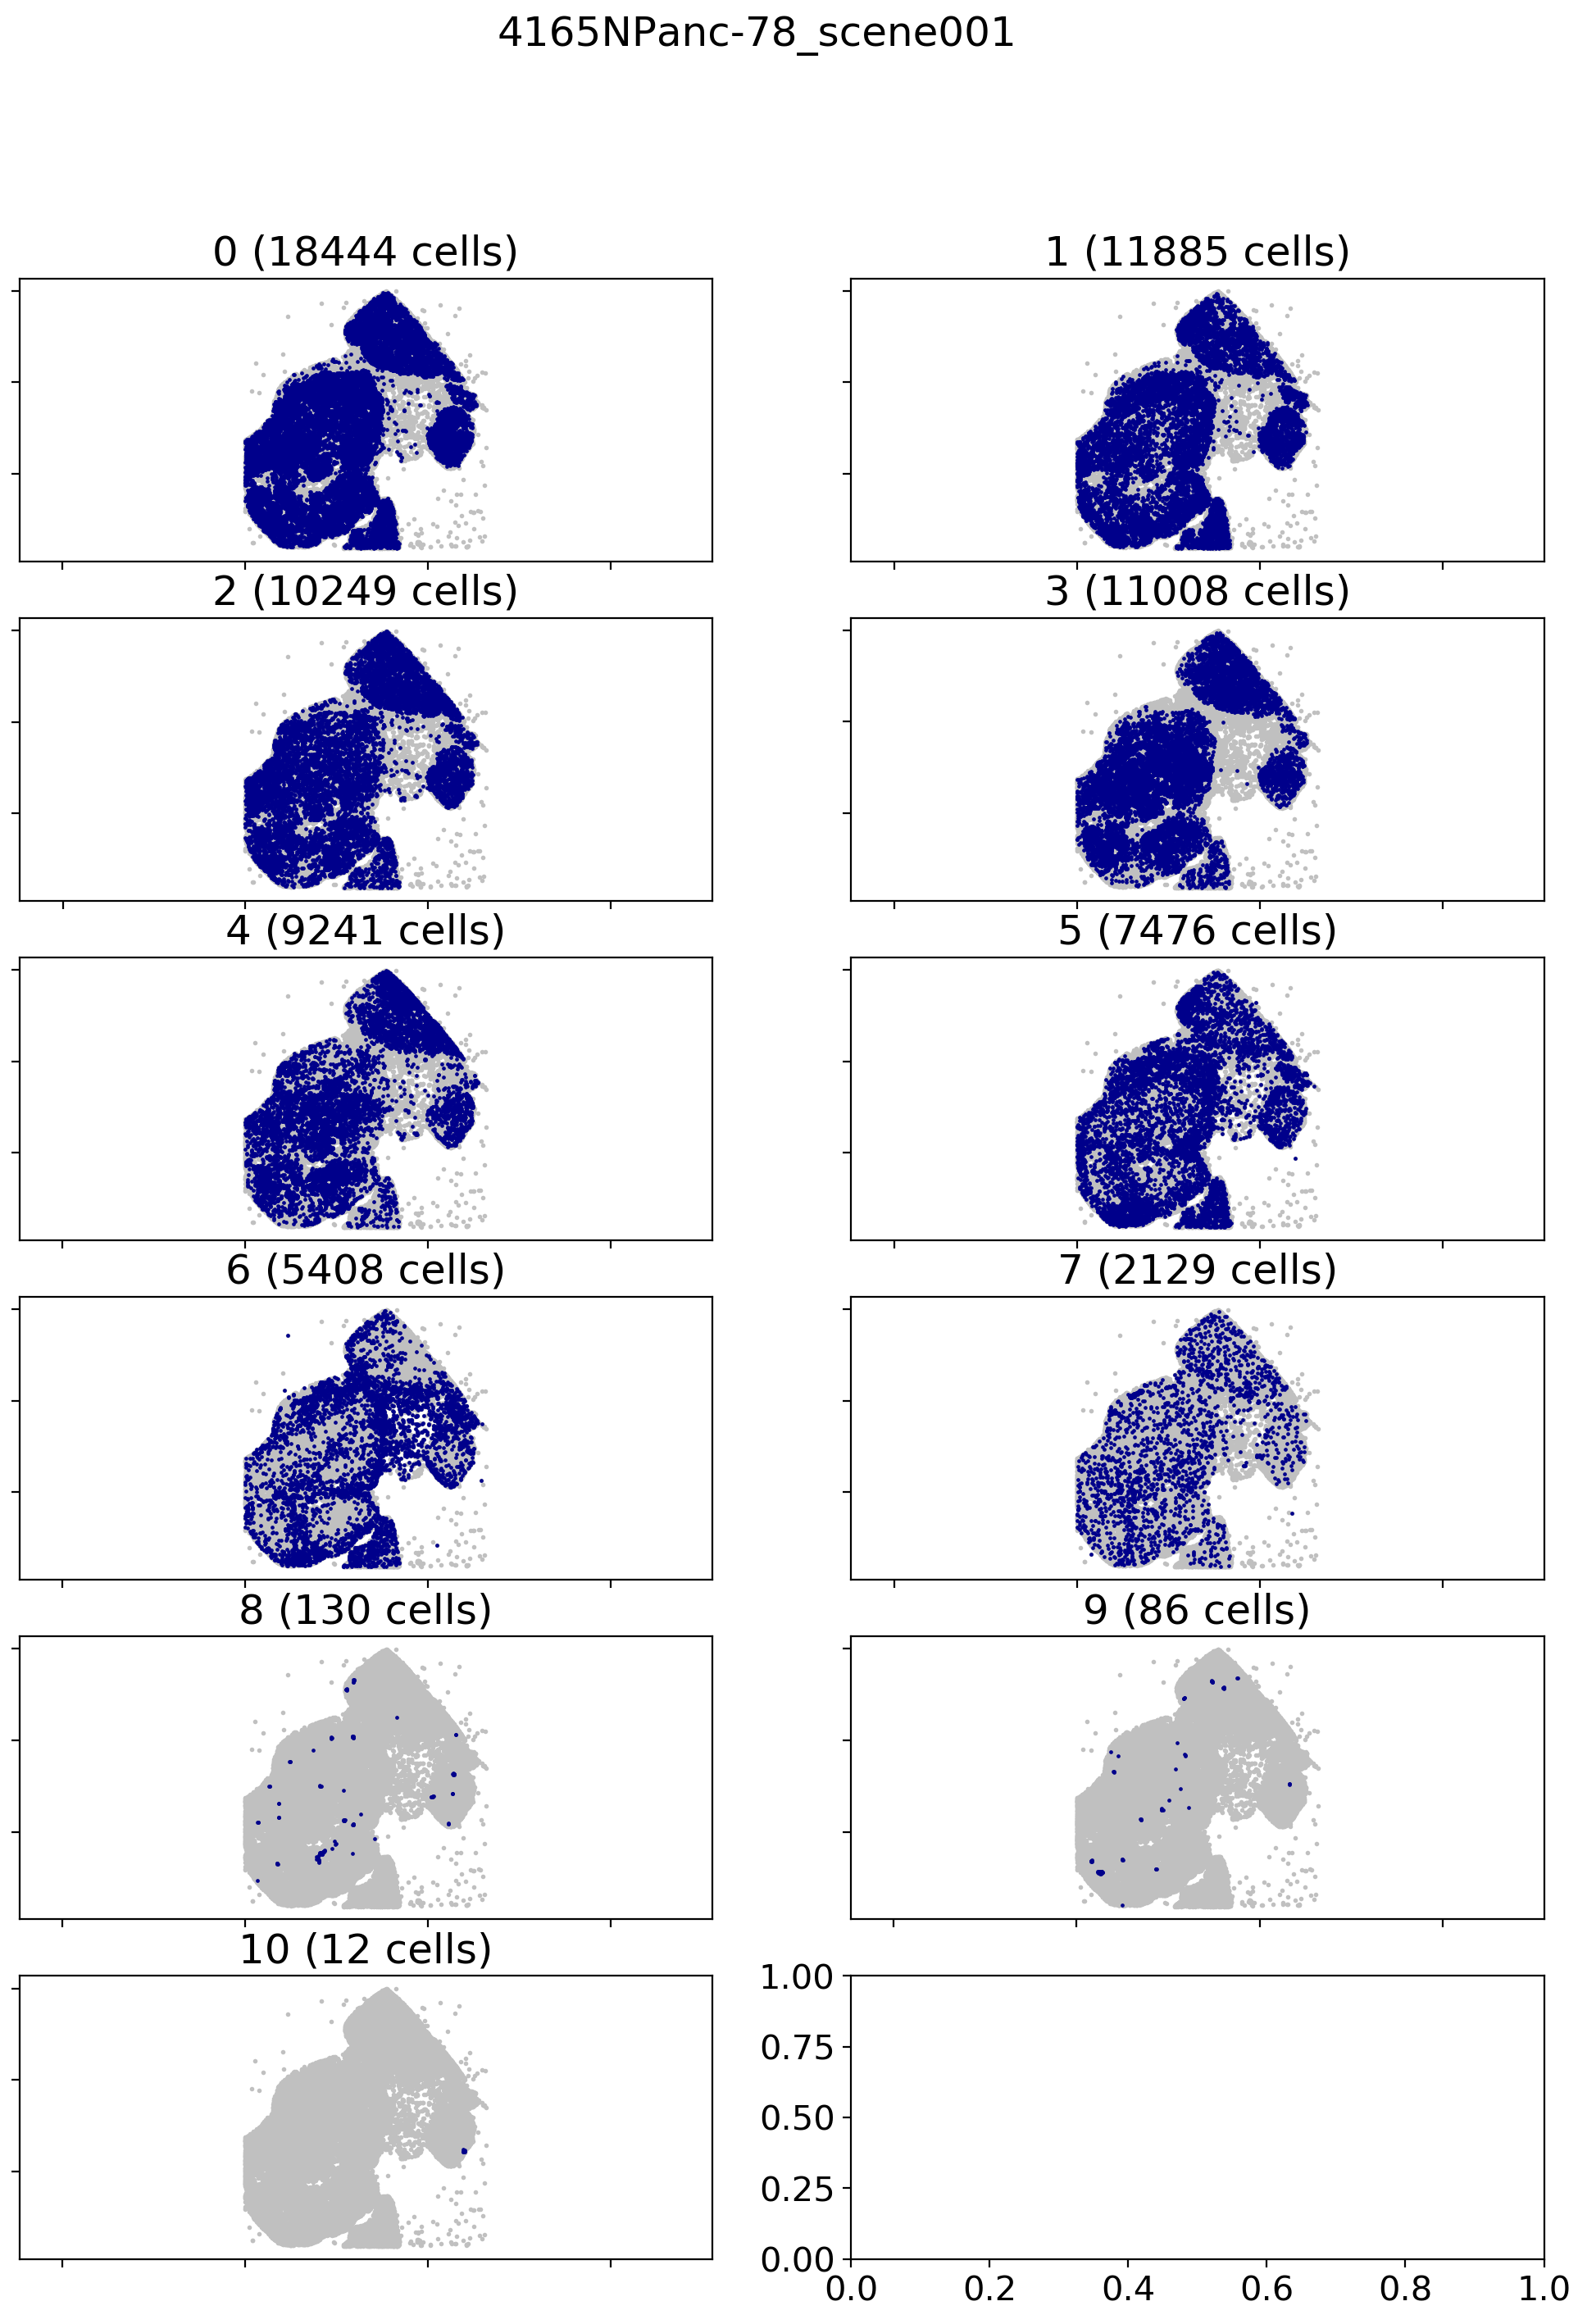

In [14]:
#load
df_lei = pd.read_csv(f'{codedir}/Data/4165NPanc_AF_norm_leiden.csv', index_col=0)
from mplex_image import visualize as viz
import importlib
importlib.reload(viz)
#df_lei = pd.DataFrame(adata.obs['leiden'],dtype='int64')
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
ls_fig = plot_clusters(df_lei,df_xy)
for idx, fig in enumerate(ls_fig):
    fig.savefig(f'{codedir}/Figures/4165NPanc/SpatialPlots_{ls_sample[idx]}_Leiden.png')
    plt.show(fig)

In [18]:
#save results
results_file = f'{codedir}/Data/4165NPanc_AF_norm_leiden.h5ad'  # the file that will store the analysis results
adata.write(results_file)

In [69]:
#save as csv
df_data = pd.DataFrame(adata.X, columns = adata.var.index, index = adata.obs.index)
df_raw = pd.DataFrame(rdata.raw.X, columns = adata.var.index, index = adata.obs.index)

In [70]:
#save to csv
df_data.merge(adata.obs,left_index=True,right_index=True).to_csv(f'{codedir}/Data/4165NPanc_AF_norm_leiden.csv')
df_raw.merge(adata.obs,left_index=True,right_index=True).to_csv(f'{codedir}/Data/4165NPanc_AF_raw_leiden.csv')

# Histograms

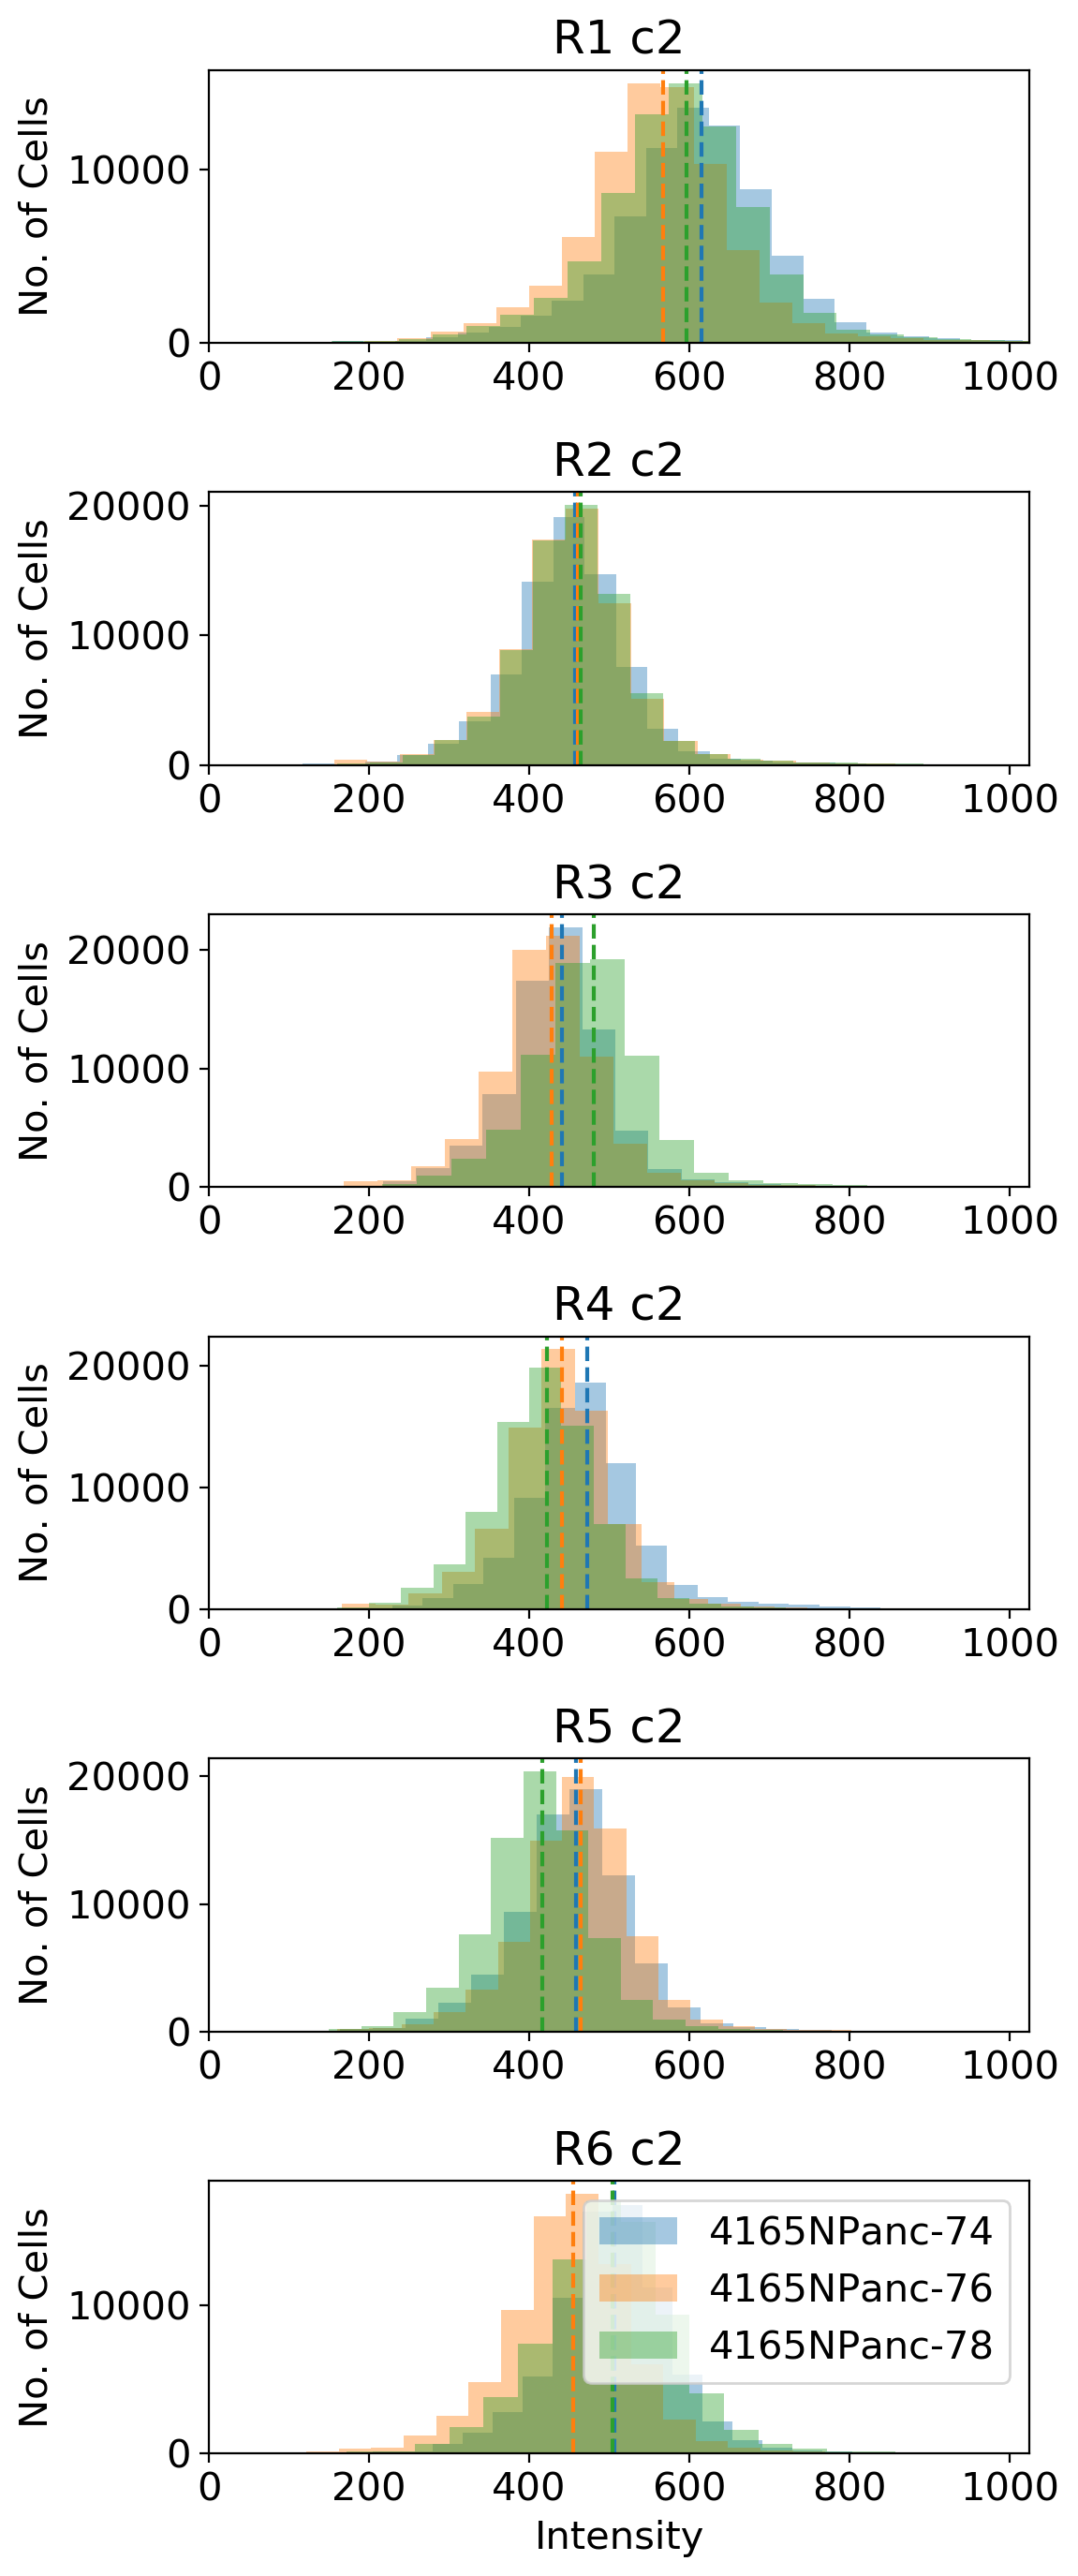

In [127]:
#histograms
df_plot = df_cyto
d_result = {}
for s_channel in ['c2','c3','c4','c5']:
    #plot single cell mean intensity
    df_channel = df_plot.loc[:,df_plot.columns.str.contains(f'{s_channel}_')]
    fig,ax = plt.subplots(6,1,figsize=(6,14),dpi=200)
    ax=ax.ravel()
    for idxs, s_sample in enumerate(ls_sample):
        df_sample = df_channel[df_channel.index.str.contains(s_sample)]
        df_sample_diff = pd.DataFrame(index=df_sample.index)        
        for idx, s_round in enumerate(['R1','R2','R3','R4','R5','R6']):
            df_round = df_sample.loc[:,df_sample.columns.str.contains(f'{s_round}c')]
            if idx == 0:
                i_max = np.quantile(df_round,.99)
            sns.distplot(df_round,bins=500,kde=False,ax=ax[idx],label=s_sample)
            i_mean = df_round.mean() 
            ax[idx].axvline(i_mean[0],ymin=0,ymax=1,color=f'C{idxs}',linestyle='--')
            ax[idx].set_xlabel('')  
            ax[idx].set_title(f'{s_round} {s_channel}')
            ax[idx].set_ylabel('No. of Cells')
            ax[idx].set_xlim(0,i_max)
            if s_round != 'R1':
                df_sample_diff[f'{s_round} - {s_last}'] = df_round.values - df_last.values
            df_last = df_round
            s_last = s_round
        ax[idx].legend()  
        ax[idx].set_xlabel(f'Intensity')
        d_result.update({s_sample:df_sample_diff})
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/4165NPanc/SingleCellDist_{s_channel}.png')
    if s_channel != 'c2':
        plt.close(fig)
